# Data Analysis On Airline On Time Performance
### LING WEI JIET, P145127
Airplane as a form of transportation is prone to variance in schedule, causing delayed arrivals or cancelled flights. These disruptions can have significant impacts on passengers and airline operations. These delays can result from a variety of factors such as weather conditions, technical issues, or air traffic congestion. Without a clear understanding of these patterns, it becomes difficult to implement effective solutions and minimize disruptions. Therefore, there is a critical need to analyze delay patterns in airlines to identify underlying causes, improve scheduling accuracy, and enhance overall efficiency in air travel.

### Aim of the analysis
The aim is to identify the reasons that cause the delays and cancellations in the U.S airline companies, and possibly suggest improvements that can be considered to tackle the problem.   
To achieve the aim, we use a dataset from Kaggle [(Data Expo 2009: Airline On Time Data)](https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=2007.csv) to perform analysis and search for answers to the following questions:
1. Delay Patterns:
- What times of day (morning/afternoon/evening) have the lowest average delays?
- Which days of the week show better on-time performance?
- During which months or seasons are flights most likely to be on time?
2. Delay Factors:
- Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset.
- Quantify the impact of each factor (in minutes of delay and percentage of total delays).
3. Cancellation Analysis:
- Identify the primary reasons for flight cancellations as categorized in the dataset.
- Determine if cancellations correlate with specific airlines, airports, or time periods.
4. Problematic Routes:
- Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.
- Analyse the reasons these particular flights are prone to delays or cancellations.


### Setup
Hive is used to store the data and Python will be used for data analysis and visualization. The data is queried and passed into a Python Dataframe for further transformation. In the next few cells, we setup the connection to Hive in the virtual machine and define some helper function for loading the data. We briefly look at the sample data before proceeding.

In [402]:
# Set up the connection to virtual machine and hive
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)

cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airline_2007',), ('airports',), ('carriers',), ('plane_data',)]


In [ ]:
# Library for data processing
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 30)

import numpy as np
from impala.error import ProgrammingError
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from IPython.display import display
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import squarify
import re

# Helper function to populate a dataframe with HiveQl query result
def execute_to_df(query, verbose = True):
    
    # Query take HiveQL query
    # col_names is a list of names, matching the number of columns, optional
    printv("="*20, verbose)
    printv("Executing ...\n>>>", verbose)
    printv(query, verbose)        
    cursor.execute(query)
    
    # Return data in a dataframe if there is output from HiveQL execution
    # If success but no result (DML/DDL), then need to handle the exception
    try:
        result = cursor.fetchall()
        printv("Result fetched.", verbose)
    except ProgrammingError as e:
        if "no results" in str(e):
            print("Operation success, no results to fetch.")
            return(False)
        else:
            raise
    
    if len(result): # If it has result
        df = pd.DataFrame(result)
        column_names = [item[0] for item in cursor.description] # Get column name from de uhh returned table
        column_names_clean = [re.sub('^.*\.','',name) for name in column_names] # Remove the table name prefix (like airline_2008.column)
        df.columns =  column_names_clean # Fill in the column name
        return df
    
    return "Empty rows fetched."

def printv(string, verbose):
    if verbose:
        print(string)
        
def decimal_scale(x): # 
    max_val = df['total_depdelay_minute'].abs().max()
    scaling_factor = 10 ** np.floor(np.log10(max_val))
    return x / scaling_factor

In [3]:
execute_to_df("SELECT * FROM airline_2007 LIMIT 19")

Executing ...
>>>
SELECT * FROM airline_2007 LIMIT 19
Result fetched.


,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,,0,0,0,0,0,0
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,,0,0,0,0,0,0
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,,0,3,0,0,0,31
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,,0,23,0,0,0,3
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,2007,1,1,1,1251,1245,1405,1410,WN,933,N413,74,85,65,-5,6,SMF,SAN,480,2,7,0,,0,0,0,0,0,0
15,2007,1,1,1,1729,1645,1843,1810,WN,1054,N416,74,85,64,33,44,SMF,SAN,480,3,7,0,,0,3,0,0,0,30
16,2007,1,1,1,825,825,941,950,WN,1106,N383SW,76,85,63,-9,0,SMF,SAN,480,3,10,0,,0,0,0,0,0,0
17,2007,1,1,1,1042,1040,1158,1205,WN,1554,N316SW,76,85,66,-7,2,SMF,SAN,480,2,8,0,,0,0,0,0,0,0


In [324]:
# 20 distinct uniquecarrier (airlines)
# 5505 distinct tailnum (aeroplane plate number)
# 304 distinct origin (airport)
# 310 distinct dest (airport)
# 5342 distinct origin, dest pair (routes)
# 7596 distinct flightnum (schedule?)
display(execute_to_df("SELECT DISTINCT uniquecarrier FROM airline_2007 LIMIT 10000"))
display(execute_to_df("SELECT DISTINCT tailnum FROM airline_2007 LIMIT 10000"))
display(execute_to_df("SELECT DISTINCT origin FROM airline_2007 LIMIT 10000"))
display(execute_to_df("SELECT DISTINCT dest FROM airline_2007 LIMIT 10000"))
display(execute_to_df("SELECT DISTINCT origin, dest FROM airline_2007 LIMIT 10000"))
display(execute_to_df("SELECT DISTINCT flightnum FROM airline_2007 LIMIT 10000"))

#### Variables explanation
[Carlson Hoo](https://carlson-hoo.medium.com/data-expo-2009-airline-on-time-performance-analysis-bb2e5bcf3042) has provided a clear explanation for each of variable in this table, showed below:
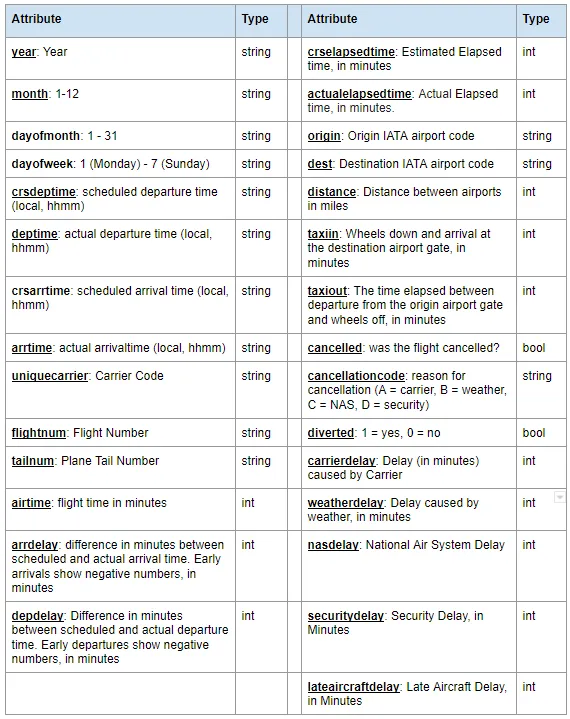

# 1. Delay Pattern

In [4]:
# When describing a flight based on a time, the time will always refered to the scheduled departure time, so flights at 5a.m. means any flight that is scheduled to depart within 0500 to 0559.
query = """
    SELECT 
        FLOOR(crsdeptime/100) as hour_time, -- Remove last two digit (minutes value), extract only the hours value
        AVG (CASE WHEN depdelay > 0 THEN 1 ELSE 0 END) as depdelay_chance,
        AVG (CASE WHEN depdelay > 0 THEN depdelay END) as avg_depdelay_minute, 
        SUM (CASE WHEN depdelay > 0 THEN depdelay END) as total_depdelay_minute,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (CASE WHEN arrdelay > 0 THEN arrdelay END) as avg_arrdelay_minute,
        SUM (CASE WHEN arrdelay > 0 THEN arrdelay END) as total_arrdelay_minute
    FROM airline_2007
    GROUP BY FLOOR(crsdeptime/100)
    ORDER BY hour_time
    LIMIT 30
"""
timeofday_delay = execute_to_df(query)
display(timeofday_delay)

Executing ...
>>>

    SELECT 
        FLOOR(crsdeptime/100) as hour_time, -- Remove last two digit (minutes value), extract only the hours value
        AVG (CASE WHEN depdelay > 0 THEN 1 ELSE 0 END) as depdelay_chance,
        AVG (CASE WHEN depdelay > 0 THEN depdelay END) as avg_depdelay_minute, 
        SUM (CASE WHEN depdelay > 0 THEN depdelay END) as total_depdelay_minute,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (CASE WHEN arrdelay > 0 THEN arrdelay END) as avg_arrdelay_minute,
        SUM (CASE WHEN arrdelay > 0 THEN arrdelay END) as total_arrdelay_minute
    FROM airline_2007
    GROUP BY FLOOR(crsdeptime/100)
    ORDER BY hour_time
    LIMIT 30

Result fetched.


,hour_time,depdelay_chance,avg_depdelay_minute,total_depdelay_minute,arrdelay_chance,avg_arrdelay_minute,total_arrdelay_minute
0,0,0.339177,27.413803,91754.0,0.439907,24.458880,106176.0
1,1,0.369821,26.635125,35185.0,0.415174,25.192852,37361.0
2,2,0.350755,29.413907,8883.0,0.429733,27.281081,10094.0
3,3,0.353474,44.393162,5194.0,0.368580,39.344262,4800.0
4,4,0.250307,45.196078,9220.0,0.391411,29.489028,9407.0
...,...,...,...,...,...,...,...
19,19,0.518294,39.299569,8904064.0,0.535725,39.872227,9337637.0
20,20,0.544048,39.636764,6423098.0,0.537085,40.600219,6495020.0
21,21,0.512503,35.827937,4606362.0,0.538010,34.970141,4719850.0
22,22,0.472664,31.365562,1356686.0,0.516320,30.870389,1458595.0


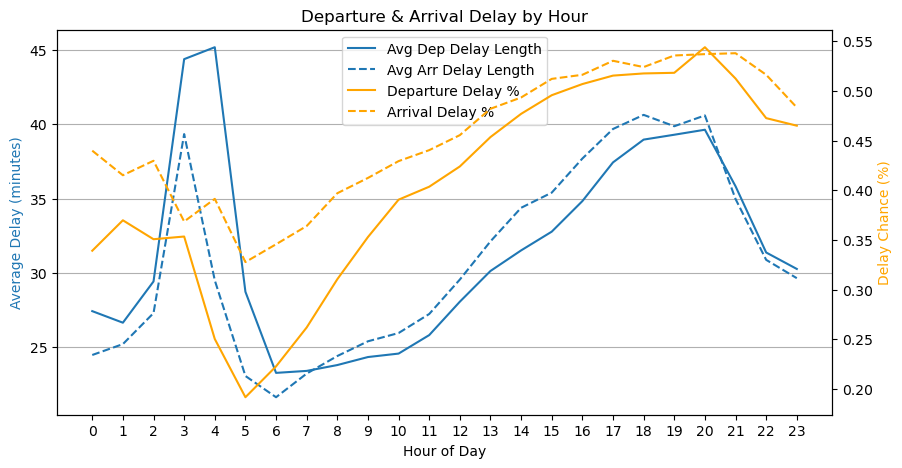

In [6]:
df = timeofday_delay
fig, ax1 = plt.subplots(figsize=(10, 5))

line1, = ax1.plot(df['hour_time'], df['avg_depdelay_minute'], label='Avg Dep Delay Length')
ax1.plot(df['hour_time'], df['avg_arrdelay_minute'], linestyle='--', color=line1.get_color(), label='Avg Arr Delay Length')

ax1.set_ylabel('Average Delay (minutes)', color = line1.get_color())
ax1.set_xlabel('Hour of Day')
ax1.set_xticks(range(0, 24))
ax1.grid(True, axis='y')

ax2 = ax1.twinx()
line2, = ax2.plot(df['hour_time'], df['depdelay_chance'], color='orange', label='Departure Delay %')
ax2.plot(df['hour_time'], df['arrdelay_chance'], linestyle='--', color=line2.get_color(), label='Arrival Delay %')
ax2.set_ylabel('Delay Chance (%)', color = line2.get_color())

ax_line1, labels1 = ax1.get_legend_handles_labels()
ax_line2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(ax_line1 + ax_line2, labels1 + labels2, loc='upper center')

plt.title('Departure & Arrival Delay by Hour')
plt.show()

Question: What times of day (morning/afternoon/evening) have the lowest average delays?  
Answer: Early morning after 05:00 has the lowest average delays

### Findings
#### Delay duration in minutes (blue lines)
Comparing delay duration between departure and arrival, both show similar pattern with several differences:  
- Departure delay is 5–15 minutes longer than arrival delay very early in the morning (03:00–06:00) period, and arrival delay is shorter for the rest of the day but by a smaller margin.  
- Max delay length is 45 minutes, and minimum delay is 25 minutes.  

Both delays peak around the periods of 0300–0600 and 1700–2000.  
#### Delay chance (orange lines)
Delay chance ranges from 20% to 55%, 
Comparing delay chance between departure and arrival:
- Departure is less likely to get delayed than arrival
- Departure delay is much rarer than arrival delay (5~10% less likely) during period 03:00 ~ 07:00

#### Relationship between delay chance and delay length
On the period of 06:00 ~ 01:00 the next day, the delay chance is positively correlated with the delay length.  
On the period 01:00 ~ 06:00 however, the chance of delay is lower, but if it delays, the delay length is much longer.
### Interpretation and Recommendation
For customers, arrival delay is more impactful than departure delay. Therefore:
- For early morning flights, avoid flight scheduled to depart within time period 02:00 ~ 04:00, and preferably 05:00 ~ 08:00. However, if the schedule cannot fit the later flight, it is still better to move the flights earlier to around 00:00, although the chance of delay is slightly higher, the delay will be much shorter. 
- For late night flights, avoid flight before 22:00, and aim for period around midnight 00:00
- On average such arrangements reduce up to 20 minutes of delay time on arrival.  

For airlines company, there are several points of consideration for improvement:
- The early morning bad performance coincides with the crew duty limit time, when the crew goes back to work at 5, the performance quickly returns back to the best condition.
- Late evening performance is gradually lowering, it might suggest the crews getting more tired or the flights are more congested during this period.  

The company should consider some crew backups to cater for delays, and implement crew rest compliance monitoring to ensure workforce are available when needed. Alternatively, if previous recommendation is undesirable due to financial reason, consider negotiating with the crew (internal-facing) to move flights to earlier/later period while promoting flights (customer-facing) during the golden hours of 06:00 ~ 09:00 period.

In [7]:
query = """
    SELECT dayofweek,
        AVG (CASE WHEN depdelay > 0 THEN 1 ELSE 0 END) as depdelay_chance,
        AVG (CASE WHEN depdelay > 0 THEN depdelay END) as avg_depdelay_minute, 
        SUM (CASE WHEN depdelay > 0 THEN depdelay END) as total_depdelay_minute,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (CASE WHEN arrdelay > 0 THEN arrdelay END) as avg_arrdelay_minute,
        SUM (CASE WHEN arrdelay > 0 THEN arrdelay END) as total_arrdelay_minute
    FROM airline_2007
    GROUP BY dayofweek
    ORDER BY dayofweek
    LIMIT 20
"""
weekday_delay = execute_to_df(query)
display(weekday_delay)

Executing ...
>>>

    SELECT dayofweek,
        AVG (CASE WHEN depdelay > 0 THEN 1 ELSE 0 END) as depdelay_chance,
        AVG (CASE WHEN depdelay > 0 THEN depdelay END) as avg_depdelay_minute, 
        SUM (CASE WHEN depdelay > 0 THEN depdelay END) as total_depdelay_minute,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (CASE WHEN arrdelay > 0 THEN arrdelay END) as avg_arrdelay_minute,
        SUM (CASE WHEN arrdelay > 0 THEN arrdelay END) as total_arrdelay_minute
    FROM airline_2007
    GROUP BY dayofweek
    ORDER BY dayofweek
    LIMIT 20

Result fetched.


,dayofweek,depdelay_chance,avg_depdelay_minute,total_depdelay_minute,arrdelay_chance,avg_arrdelay_minute,total_arrdelay_minute
0,1,0.434612,31.545107,15251870.0,0.468858,32.392240,16895533.0
1,2,0.378037,30.569555,12464308.0,0.431810,31.015238,14444851.0
2,3,0.397775,31.926674,13828081.0,0.455453,32.254327,15995695.0
3,4,0.437865,33.381133,16045009.0,0.494170,34.123911,18511164.0
4,5,0.463748,32.685463,16699199.0,0.509480,33.507251,18807218.0
5,6,0.400322,27.823695,10395934.0,0.409635,28.722618,10981461.0
6,7,0.437517,31.600348,14386406.0,0.465251,32.734320,15847339.0


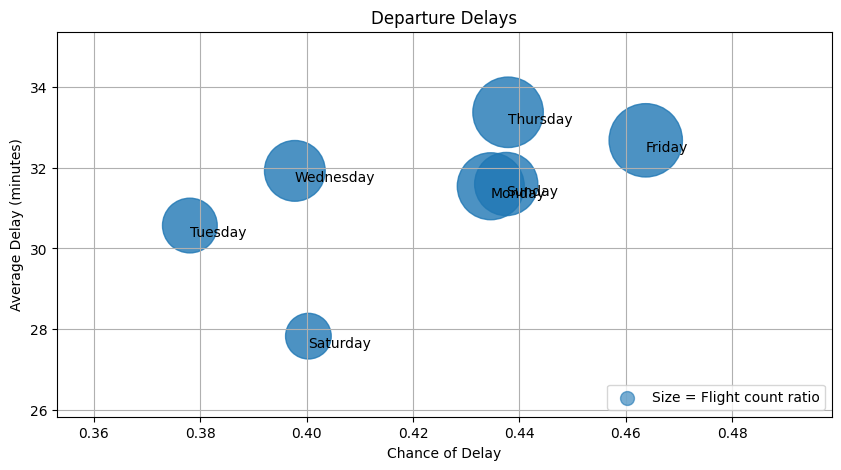

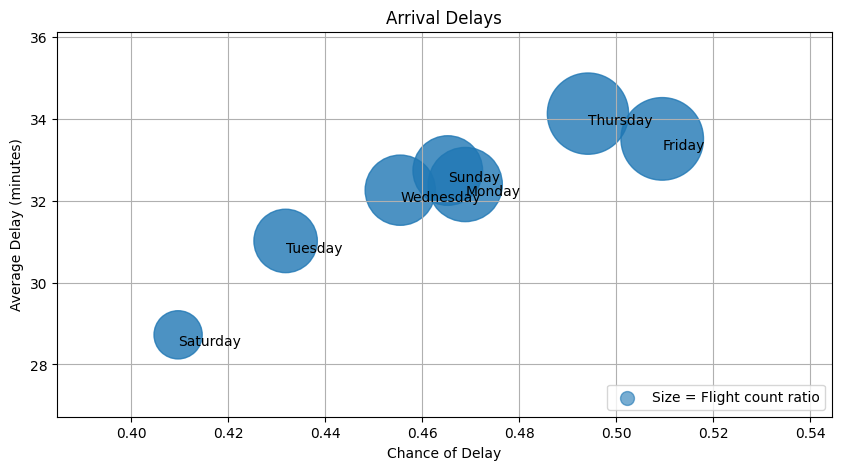

In [32]:
import matplotlib.pyplot as plt

weekday_dict = {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday", 7:"Sunday"}

df = weekday_delay
# Departure delay scatter plot
plt.figure(figsize=(10, 5))

plt.scatter(
    df['depdelay_chance'],
    df['avg_depdelay_minute'],
    s=df['total_depdelay_minute'].apply(decimal_scale) ** 2 * 1000,
    alpha=0.8
)

plt.scatter([], [], s=100, color='C0', label='Size = Flight count ratio', alpha=0.6)
plt.legend(loc='lower right')

plt.title('Departure Delays')
plt.xlabel('Chance of Delay')
plt.ylabel('Average Delay (minutes)')
plt.xlim(min(df['depdelay_chance']) - 0.025, max(df['depdelay_chance']) + 0.035)
plt.ylim(min(df['avg_depdelay_minute']) - 2, max(df['avg_depdelay_minute']) + 2)

for i in range(len(df)):
    plt.text(
        df['depdelay_chance'][i],
        df['avg_depdelay_minute'][i],
        weekday_dict.get(df['dayofweek'][i]),
        va = 'top'
    )
plt.grid(True, zorder=0)
plt.show()

plt.figure(figsize=(10, 5))

plt.scatter(
    df['arrdelay_chance'],
    df['avg_arrdelay_minute'],
    s=df['total_arrdelay_minute'].apply(decimal_scale) ** 2 * 1000,
    alpha=0.8
)

plt.scatter([], [], s=100, color='C0', label='Size = Flight count ratio', alpha=0.6)
plt.legend(loc='lower right')

plt.title('Arrival Delays')
plt.xlabel('Chance of Delay')
plt.ylabel('Average Delay (minutes)')
plt.xlim(min(df['arrdelay_chance']) - 0.025, max(df['arrdelay_chance']) + 0.035)
plt.ylim(min(df['avg_arrdelay_minute']) - 2, max(df['avg_arrdelay_minute']) + 2)

for i in range(len(df)):
    plt.text(
        df['arrdelay_chance'][i],
        df['avg_arrdelay_minute'][i],
        weekday_dict.get(df['dayofweek'][i]),
        va = 'top'
    )
plt.grid(True, zorder=0)
plt.show()

Question: Which days of the week show better on-time performance?  
Answer: Saturday and Tuesday have the best on time performance

### Findings, interpretation, recommendation
Both departure and arrival shows similar pattern  
Worst day of the week to have flight are Thursday and Friday, best day to have flight are Saturday and Tuesday.  
Additionally, Saturday has the least amount of traffic, it is the best day to schedule the flight for people who like to avoid busy days.  

In [9]:
query = """
    SELECT month,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (arrdelay) as avg_arrdelay_minute
    FROM airline_2007
    GROUP BY month
    ORDER BY month
    LIMIT 20
"""
month_delay = execute_to_df(query)
display(month_delay)

Executing ...
>>>

    SELECT month,
        AVG (CASE WHEN arrdelay > 0 THEN 1 ELSE 0 END) as arrdelay_chance,
        AVG (arrdelay) as avg_arrdelay_minute
    FROM airline_2007
    GROUP BY month
    ORDER BY month
    LIMIT 20

Result fetched.


,month,arrdelay_chance,avg_arrdelay_minute
0,1,0.460671,9.162152
1,10,0.428732,6.508259
2,11,0.401095,4.793344
3,12,0.541325,16.213714
4,2,0.502387,13.519795
...,...,...,...
7,5,0.435922,7.037889
8,6,0.518761,16.179528
9,7,0.503514,14.107680
10,8,0.485546,12.571533


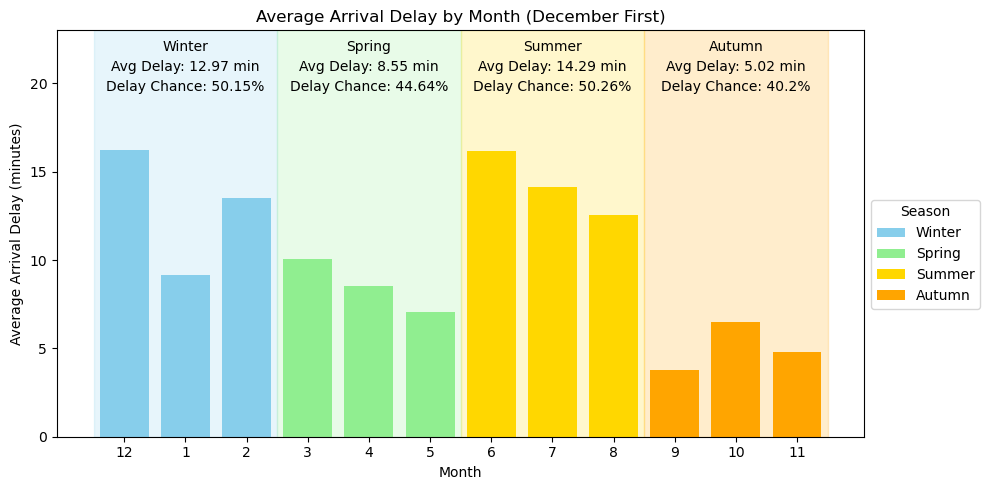

In [21]:
# Reorder month so December comes first
df = month_delay
df['month'] = df['month'].astype(int)
df['month_ordered'] = df['month'].apply(lambda m: m - 12 if m == 12 else m)
df = df.sort_values('month_ordered').reset_index(drop=True)

# Define season colors
season_colors = {
    'Winter': 'skyblue',
    'Spring': 'lightgreen',
    'Summer': 'gold',
    'Autumn': 'orange'
}

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)
colors = df['season'].map(season_colors)

df['group'] = df.index // 3
avg_across_season = df.groupby('group').agg({'avg_arrdelay_minute': 'mean', 'arrdelay_chance': 'mean'}).reset_index(drop=True)

# Update plot
fig, ax = plt.subplots(figsize=(10, 5))

# Add seasonal background spans (adjusted for new month positions)
season_positions = {
    'Winter': [(0, 2)],
    'Spring': [(3, 5)],
    'Summer': [(6, 8)],
    'Autumn': [(9, 11)],
}
for season, spans in season_positions.items():
    for start, end in spans:
        ax.axvspan(start - 0.5, end + 0.5, color=season_colors[season], alpha=0.2)

# Plot bars
ax.bar(range(12), df['avg_arrdelay_minute'], color=df['season'].map(season_colors))
ax.set_ylim(0,23)

# Label average chance and uh minute
for i, x_pos in enumerate([1, 4, 7, 10]):
    ax.text(x_pos, ax.get_ylim()[1]*0.95, f"{df.season.iloc[x_pos]}", ha='center', fontsize=10)
    val = round(avg_across_season.iloc[i, 0], 2)
    ax.text(x_pos, ax.get_ylim()[1]*0.90, f"Avg Delay: {val} min", ha='center', fontsize=10)
    chance = round(avg_across_season.iloc[i, 1]*100, 2)
    ax.text(x_pos, ax.get_ylim()[1]*0.85, f"Delay Chance: {chance}%", ha='center', fontsize=10)

# X-axis labels
ax.set_xticks(range(12))
ax.set_xticklabels(df['month'])

# Labels and legend
ax.set_xlabel('Month')
ax.set_ylabel('Average Arrival Delay (minutes)')
ax.set_title('Average Arrival Delay by Month (December First)')
legend_elements = [Patch(facecolor=color, label=season) for season, color in season_colors.items()]
ax.legend(handles=legend_elements, title='Season', loc='upper left', bbox_to_anchor=(1., 0.6))

plt.tight_layout()
plt.show()


Question: During which months or seasons are flights most likely to be on time?  
Answer: Months that are most likely to be on time are September to November, the Autumn season. 
<br></br>
Note: Months are separated into seasons according to [meteorological season](https://www.rmets.org/metmatters/difference-between-meteorological-and-astronomical-seasons#:~:text=Meteorological%20seasons&text=Spring%20is%20then%20defined%20as,February%20(the%20coldest%20months).) in this analysis

### Findings
- Autumn season is the best choice for on-time performance, having only 40.2% chance to delay and averaged a delay of 5 minutes.
- Spring follow closely in terms of performance, having slightly higher delay chance and delay time of 44.64% and 8.55 minutes.
- Winter and Summer are the worse performing season, having around 50% chance of delay. 
- Summer has the worst delay time, 14.29 minutes, almost 3x the average delay on autumn.  

Performance within season itself is close, but the changes across season is very obvious.
### Interpretation, recommendation
The interpretation is simple, people choose plan their schedule around events, which is closely related to seasons, such as school holiday etc.  
The recommendation is to plan the schedule around Autumn or Spring to have the best flying experience. The other thing is to try to avoid summer season, maybe travel on May instead of June, or September instead of August to greatly reduce the chance and duration of delay.

# 2. Delay Factors

In [234]:
query = """
    SELECT 
        SUM(arrdelay) as total_arrival_delay
    FROM airline_2007
    WHERE arrdelay>0
"""
total_arrival_delay = execute_to_df(query)
display(total_arrival_delay)

query = """
    SELECT
        SUM(carrierdelay) as total_carrierdelay,
        SUM(weatherdelay) as total_weatherdelay,
        SUM(nasdelay) as total_nasdelay,
        SUM(securitydelay) as total_securitydelay,
        SUM(lateaircraftdelay) as total_lateaircraftdelay       
    FROM airline_2007
"""
delay_reason = execute_to_df(query)
delay_reason['unexplained'] = total_arrival_delay - delay_reason.sum(axis=1)[0]
display(delay_reason)

Executing ...
>>>

    SELECT 
        SUM(arrdelay) as total_arrival_delay
    FROM airline_2007
    WHERE arrdelay>0

Result fetched.


,total_arrival_delay
0,111483261


Executing ...
>>>

    SELECT
        SUM(carrierdelay) as total_carrierdelay,
        SUM(weatherdelay) as total_weatherdelay,
        SUM(nasdelay) as total_nasdelay,
        SUM(securitydelay) as total_securitydelay,
        SUM(lateaircraftdelay) as total_lateaircraftdelay       
    FROM airline_2007

Result fetched.


,total_carrierdelay,total_weatherdelay,total_nasdelay,total_securitydelay,total_lateaircraftdelay,unexplained
0,28808434,5739649,28200746,176906,38004942,10552584


In [212]:
query = """
    SELECT
        AVG (CASE WHEN carrierdelay > 0 THEN 1 ELSE 0 END) as carrierdelay_chance,
        AVG (CASE WHEN weatherdelay > 0 THEN 1 ELSE 0 END) as weatherdelay_chance,
        AVG (CASE WHEN nasdelay > 0 THEN 1 ELSE 0 END) as nasdelay_chance,
        AVG (CASE WHEN securitydelay > 0 THEN 1 ELSE 0 END) as securitydelay_chance,
        AVG (CASE WHEN lateaircraftdelay > 0 THEN 1 ELSE 0 END) as lateaircraftdelay_chance
    FROM airline_2007
    WHERE arrdelay > 0
"""
delay_chance = execute_to_df(query)
display(delay_chance)
print(f"Sum: {sum(delay_chance.iloc[0,:])}")
unexplained =  1-sum(delay_chance.iloc[0,:])
delay_chance['unexplained_proportion'] = unexplained
delay_reason['unexplained_proportion'] = 0
print(f"Unexplained proportion: {round(unexplained,2)}%")

Executing ...
>>>

    SELECT
        AVG (CASE WHEN carrierdelay > 0 THEN 1 ELSE 0 END) as carrierdelay_chance,
        AVG (CASE WHEN weatherdelay > 0 THEN 1 ELSE 0 END) as weatherdelay_chance,
        AVG (CASE WHEN nasdelay > 0 THEN 1 ELSE 0 END) as nasdelay_chance,
        AVG (CASE WHEN securitydelay > 0 THEN 1 ELSE 0 END) as securitydelay_chance,
        AVG (CASE WHEN lateaircraftdelay > 0 THEN 1 ELSE 0 END) as lateaircraftdelay_chance
    FROM airline_2007
    WHERE arrdelay > 0

Result fetched.


,carrierdelay_chance,weatherdelay_chance,nasdelay_chance,securitydelay_chance,lateaircraftdelay_chance
0,0.235973,0.037021,0.30238,0.002684,0.242829


Sum: 0.8208869089071669
Unexplained proportion: 0.18%


,Delay Duration,Delay Chance
Carrier Reason,0.258410,0.235973
National Air \nSystem Reason,0.051484,0.037021
Weather Reason,0.252959,0.302380
Security Reason,0.001587,0.002684
Late Aircraft,0.340903,0.242829
Unexplained,0.094656,0.179113


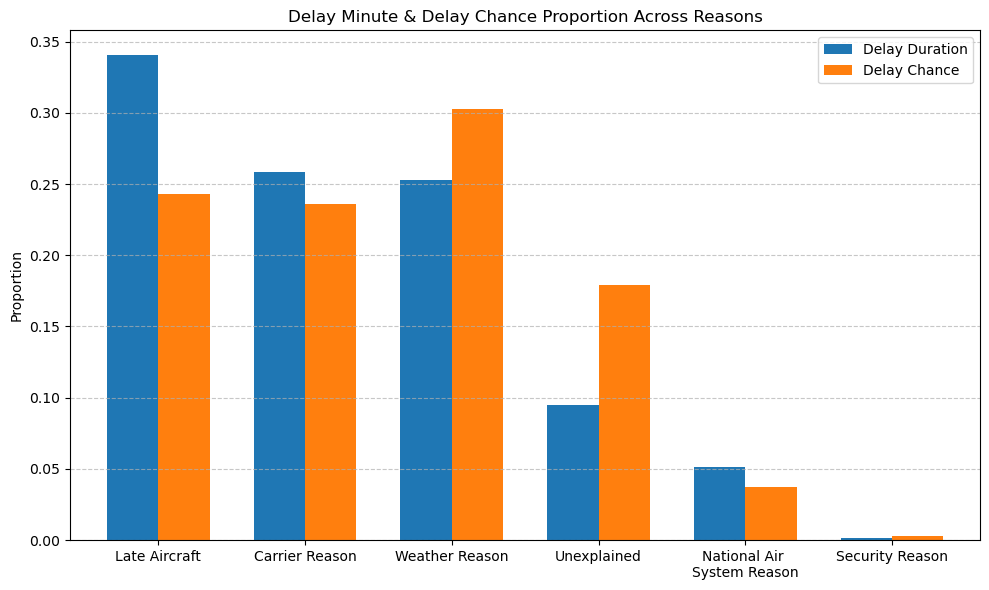

In [241]:
delay_reason_chance = pd.concat([delay_reason.T.reset_index(drop=True),delay_chance.T.reset_index(drop=True)],axis=1)
delay_reason_chance.index = ['Carrier Reason', 'National Air \nSystem Reason', 'Weather Reason', 'Security Reason', 'Late Aircraft', 'Unexplained']
delay_reason_chance.columns = ['Delay Duration','Delay Chance']
delay_reason_chance['Delay Duration'] = delay_reason_chance['Delay Duration'] / delay_reason_chance['Delay Duration'].sum()
display(delay_reason_chance)

df = delay_reason_chance
df_sorted = df.sort_values(by='Delay Duration', ascending=False)

ax = df_sorted.plot(kind='bar', figsize=(10, 6), width=0.7)
ax.set_ylabel("Proportion")
ax.set_title("Delay Minute & Delay Chance Proportion Across Reasons")
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Questions: Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset.  
Answer: The primary reasons in order of severe to less severe: Late aircraft, carrier reason, weather reason.
<br></br>
Questions: Quantify the impact of each factor (in minutes of delay and percentage of total delays).  
Answer: 
- Late aircraft: 20% chance, 38% of all delay duration  
- Carrier reason: 19% chance, 28% of all delay duration  
- Weather reason: 25% chance, 28% of all delay duration  
- National Air System reason: 3% chance, 6% of all delay duration  
- Security reason: Negligible chance and duration  
- Unexplained reason: around 18% occurence of delay is unexplained, but those explained delays only occupies less than 10% of the total time

### Findings, interpretation, recommendation
Findings are provided in the answer of the previous cell, so let's move on to interpretation and recommendation. The areas that require the most attention are late aircrafts, carrier reason, and weather reason.  
#### Cascading delay
Although late aircraft is not the most probable cause of delay, but it contributes to the most time wasted to due delay. This means whenever aircraft is late, the delay is always disproportionately long. This suggests the existence of cascading delays because it means the arrival of an aircraft is delayed by the late arrival of previous aircraft.  
The recommendation is to implement a "circuit breaker" protocols - if an aircraft is running 25+ (values can be finetuned in the future) minutes late, automatically swap it with a standby aircraft or cancel the flight entirely. The current approach of "pushing through" late aircraft is destroying the entire network efficiency.
#### Carrier reason
The problem with carrier reason is that this category is too big or unambiguous. The high percentage of delay duration and chance (25%) suggest it has a/several systematic reason(s) of failure/delay, but since it covers so many aspect of the operations, such as baggage handling, maintenance, etc., it kind of masked away the actual reason. The recommendation is to mandate a finer description / separation of the reason, so that the root-causes under carrier reason can be determined.
#### Weather reason
Weather has the highest chance of causing a delay, suggesting a weakness in determining the weather condition. The recommendation is to focus on the weather system to try to improve the accuracy so that the flight can be reschedule (and inform the customer) as early as possible, so that decision can be made earlier to adapt to it, including rerouting the flight, or rescheduling/cancelling the flight if the delay will be more than 3 to 4 hours (example threshold). Other than that, it might be wise to invest into equipment that can handle more diverse weather, such as all-weather aircraft [(Boeing 787 Dreamliner)](http://787updates.newairplane.com/787-Electrical-Systems/787-Electrical-system#:~:text=The%20787:%20A%20more%2Delectric,start%20and%20wing%20ice%20protection.) or runway tech [(ILS)](https://skybrary.aero/articles/instrument-landing-system-ils)


# 3. Cancellation Analysis

In [22]:
query = """
    SELECT
        cancellationCode,
        count(1) as quantity
    FROM airline_2007
    WHERE COALESCE(cancellationCode,'') != ''
    GROUP BY cancellationCode
"""
cancel_reason = execute_to_df(query)
display(cancel_reason)

Executing ...
>>>

    SELECT
        cancellationCode,
        count(1) as quantity
    FROM airline_2007
    WHERE COALESCE(cancellationCode,'') != ''
    GROUP BY cancellationCode

Result fetched.


,cancellationcode,quantity
0,A,66779
1,D,39
2,C,31995
3,B,61936


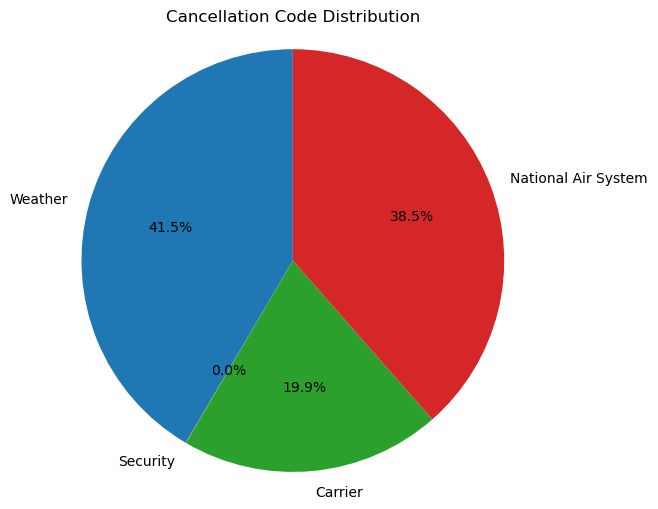

In [23]:
df = cancel_reason
plt.figure(figsize=(6, 6))
plt.pie(df['quantity'], labels=['Weather','Security','Carrier','National Air System'], autopct='%1.1f%%', startangle=90)
plt.title("Cancellation Code Distribution")
plt.axis('equal')
plt.show()

Question: Identify the primary reasons for flight cancellations as categorized in the dataset.  
Answer: Carrier and Weather are the primary reasons, responsible for a total of 80% of all the cancelled flight.

In [24]:
# Construct contigency table for all variable of interest
contigency_table_dict = {}

for variable_of_interest in ['uniquecarrier','origin','dest','floor(crsdeptime/100) as hour_time','dayofweek','month']:
    query = f"""
        SELECT
            {variable_of_interest},
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY {variable_of_interest.split(' ')[0]}, cancelled
    """
    temp_df = execute_to_df(query)
    pivot_df = temp_df.pivot(index = variable_of_interest.split(' ')[-1], columns = 'cancelled', values = 'flight_count')

    table_name = f"cancel_with_{variable_of_interest.split(' ')[-1]}"
    contigency_table_dict.update({table_name:pivot_df})
contigency_table_dict

Executing ...
>>>

        SELECT
            uniquecarrier,
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY uniquecarrier, cancelled
    
Result fetched.
Executing ...
>>>

        SELECT
            origin,
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY origin, cancelled
    
Result fetched.
Executing ...
>>>

        SELECT
            dest,
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY dest, cancelled
    
Result fetched.
Executing ...
>>>

        SELECT
            floor(crsdeptime/100) as hour_time,
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY floor(crsdeptime/100), cancelled
    
Result fetched.
Executing ...
>>>

        SELECT
            dayofweek,
            cancelled,
            COUNT(*) AS flight_count
        FROM airline_2007
        GROUP BY day

{'cancel_with_uniquecarrier': cancelled            0      1
 uniquecarrier                
 9E              250912   7939
 AA              615933  17924
 AQ               45972    388
 AS              157622   2563
 B6              187740   3710
 ...                ...    ...
 UA              478073  11929
 US              476505   8942
 WN             1158878   9993
 XE              423973  10800
 YV              283075  11287
 
 [20 rows x 2 columns],
 'cancel_with_origin': cancelled        0      1
 origin                   
 ABE         5495.0  206.0
 ABI         2726.0  110.0
 ABQ        40795.0  366.0
 ABY         1283.0   29.0
 ACK          277.0   37.0
 ...            ...    ...
 WYS          263.0    3.0
 XNA        13452.0  573.0
 YAK          710.0   16.0
 YKM          407.0    3.0
 YUM         3439.0   85.0
 
 [304 rows x 2 columns],
 'cancel_with_dest': cancelled        0      1
 dest                     
 ABE         5526.0  168.0
 ABI         2739.0   99.0
 ABQ        40

In [25]:
# Perform chi-square test for all variables against `cancelled` variable
chi2_test_dict = {}

for table_name in contigency_table_dict.keys():
    variable = table_name.split("_")[-1]
    df = contigency_table_dict.get(table_name)
    qualified_rows = df.ge(5).all(axis=1) # All value in the cell should have >=5 quantity for chisquare to be valid, so drop those < 5
    df = df[qualified_rows]
    
    chi2, pvalue, dof, expected = chi2_contingency(df)
    
    temp_dict = {'chi2': chi2, 'pvalue': pvalue, 'dof': dof, 'expected': expected}
    chi2_test_dict.update({variable:temp_dict})
    print(f"Chi-square test for {variable}: chi2:{chi2}, p-value:{pvalue}")

Chi-square test for uniquecarrier: chi2:39990.24179967899, p-value:0.0
Chi-square test for origin: chi2:52120.23396450127, p-value:0.0
Chi-square test for dest: chi2:49858.28765427202, p-value:0.0
Chi-square test for time: chi2:5481.985167121384, p-value:0.0
Chi-square test for dayofweek: chi2:1790.716850199398, p-value:0.0
Chi-square test for month: chi2:36004.50030898958, p-value:0.0


Question: Determine if cancellations correlate with specific airlines, airports, or time periods.  

Answer: Given the big number of datapoints, as long as there is an interaction effect between a variable and cancellation, it is not surprise that the relationship will be statistically significant. In our test, all chi-square test show p-value << 0.01, we have extremely significant evidence to reject our null hypothesis that (airlines/airports/time periods) has no relationship with cancellations. We accept the alternative hypothesis that these variables indeed have correlation with cancellations. We move on to checking how the affect flight cancellation count.

Executing ...
>>>
SELECT * FROM carriers LIMIT 2000
Result fetched.


,airlines,actual_cancelled_count,expected_cancelled_count,actual_vs_expected_ratio
0,9E,7939,5583.0,1.421995
1,AA,17924,13671.0,1.311096
2,AQ,388,1000.0,0.388000
3,AS,2563,3455.0,0.741823
4,B6,3710,4129.0,0.898523
...,...,...,...,...
15,UA,11929,10568.0,1.128785
16,US,8942,10470.0,0.854059
17,WN,9993,25210.0,0.396390
18,XE,10800,9377.0,1.151754


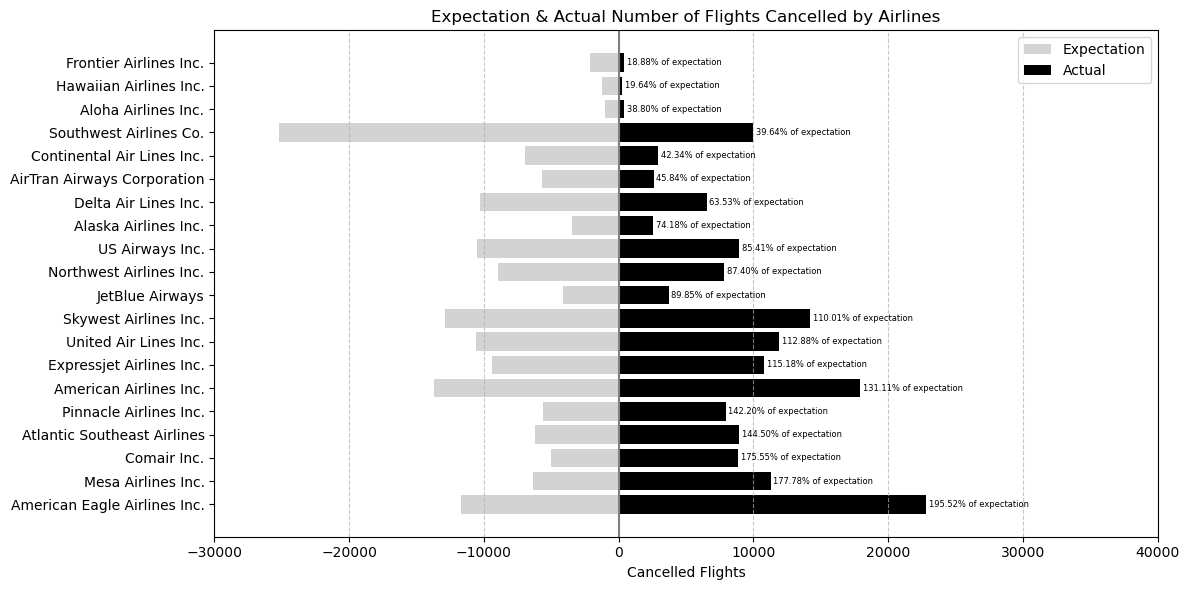

In [127]:
# Airline name translation
airline_name = execute_to_df("SELECT * FROM carriers LIMIT 2000")
def get_airline_name(code):    
    name = airline_name[airline_name['code']== code].iloc[0,1]
    clean_name = re.sub(r'Inc\..*', 'Inc.', name)
    return clean_name

# Worst carrier: bar plot sort by percentage cancelled 
actual = contigency_table_dict.get("cancel_with_uniquecarrier").iloc[:,1]
expected = round(pd.DataFrame(chi2_test_dict.get("uniquecarrier").get('expected'), index = actual.index).iloc[:,1])
df = pd.concat([actual,expected],axis=1).reset_index()
df.columns = ['airlines','actual_cancelled_count','expected_cancelled_count']
df['actual_vs_expected_ratio'] = df['actual_cancelled_count'] / df['expected_cancelled_count'] 
display(df)
df['airlines'] = df['airlines'].apply(get_airline_name)

# Sort by ratio
sorted_df = df.sort_values(by='actual_vs_expected_ratio', ascending=False).head(20)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(sorted_df['airlines'], -sorted_df['expected_cancelled_count'], color='lightgray', label='Expectation')
bars = ax.barh(sorted_df['airlines'], sorted_df['actual_cancelled_count'], color='black', label='Actual')
ax.set_xlim(-30000,40000)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add ratio text
for bar, ratio in zip(bars, sorted_df['actual_vs_expected_ratio']):
    ax.text(bar.get_width() + 200, bar.get_y() + bar.get_height() / 2,
            f'{ratio*100:.2f}% of expectation', va='center', ha='left', fontsize=6)
    
ax.set_xlabel('Cancelled Flights')
ax.set_title('Expectation & Actual Number of Flights Cancelled by Airlines')
ax.axvline(0, color='gray')
ax.legend()
plt.tight_layout()
plt.show()

### Findings  
Top 3 best performing airlines are Frontiers Airlines, Hawaiian Airlines, Aloha Airlines, which achieved cancellation count less than 40% of expectation. Southwest Airlines is also an honourable mention given the much bigger quantity of flights while still maintaining flight cancellation < 40% of expectation.  
Top 3 worst performing airlines are American Eagle Airlines, Mesa Airlines, Comair, which all achieved cancellation count more than 175% of expectation. 

,airports,actual_cancelled_count,expected_cancelled_count,actual_vs_expected_ratio
0,Lehigh Valley International,206.0,123.0,1.674797
1,Abilene Regional,110.0,61.0,1.803279
2,Albuquerque International,366.0,888.0,0.412162
3,Southwest Georgia Regional,29.0,28.0,1.035714
4,Nantucket Memorial,37.0,7.0,5.285714
...,...,...,...,...
285,Eglin Air Force Base,168.0,149.0,1.127517
286,Wrangell,22.0,16.0,1.375000
287,Northwest Arkansas Regional,573.0,303.0,1.891089
288,Yakutat,16.0,16.0,1.000000


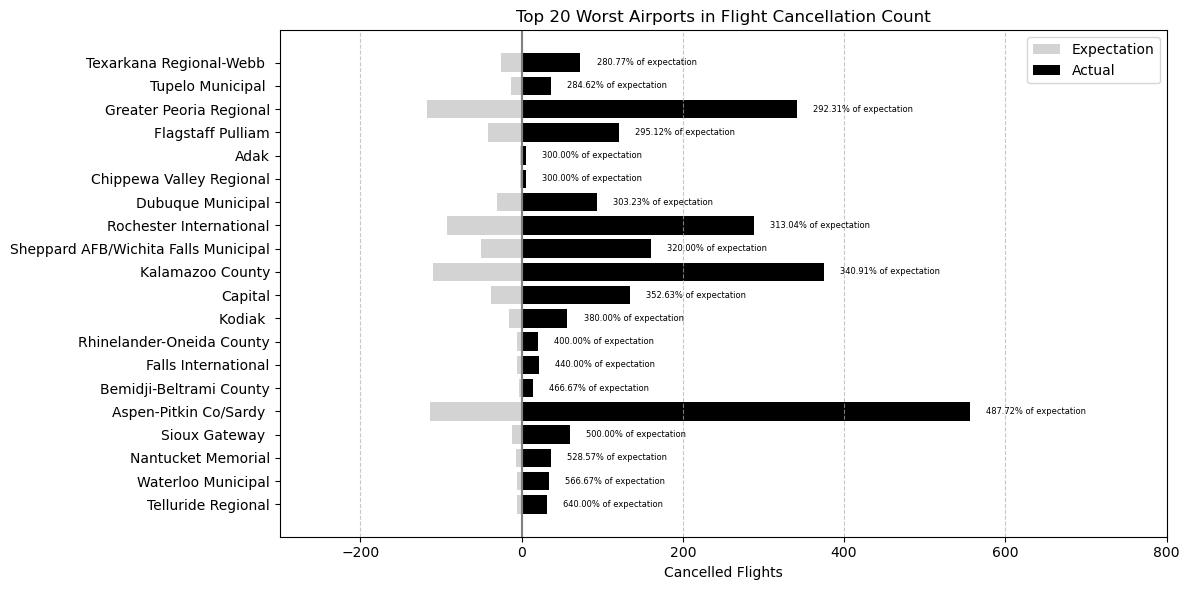

In [165]:
# Name translation
#airport_name = execute_to_df("SELECT * FROM airports LIMIT 4000")
def get_airport_name(code):    
    name = airport_name[airport_name['iata']== code].iloc[0,1]
    return name

# Worst airport: bar plot sort by percentage cancelled 
temp = contigency_table_dict.get("cancel_with_origin")
actual = temp[temp.ge(5).all(axis=1)].iloc[:,1]
expected = round(pd.DataFrame(chi2_test_dict.get("origin").get('expected'), index = actual.index).iloc[:,1])
df = pd.concat([actual,expected],axis=1).reset_index()
df.columns = ['airports','actual_cancelled_count','expected_cancelled_count']
df['actual_vs_expected_ratio'] = df['actual_cancelled_count'] / df['expected_cancelled_count'] 
df['airports'] = df['airports'].apply(get_airport_name)
display(df)

# Sort by ratio
sorted_df = df.sort_values(by='actual_vs_expected_ratio', ascending=False).head(20)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(sorted_df['airports'], -sorted_df['expected_cancelled_count'], color='lightgray', label='Expectation')
bars = ax.barh(sorted_df['airports'], sorted_df['actual_cancelled_count'], color='black', label='Actual')
ax.set_xlim(-300,800)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add ratio text
for bar, ratio in zip(bars, sorted_df['actual_vs_expected_ratio']):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height() / 2,
            f'{ratio*100:.2f}% of expectation', va='center', ha='left', fontsize=6)
    
ax.set_xlabel('Cancelled Flights')
ax.set_title('Top 20 Worst Airports in Flight Cancellation Count')
ax.axvline(0, color='gray')
ax.legend()
plt.tight_layout()
plt.show()

### Findings
Out of 3000+ airports, these 20 airports have the highest ratio of cancelled to total flights. If an airport flight cancellation rate is at least 280% higher than average, it is considered in the top 20 worst airports. Aspen-Pitkin Co/Sardy, Kalamazoo County, Rochester International, and Greater Peoria Regional are the most notorious in cancelling their flights, as they have cancelled more than 200 flights per year, which is 3x more likely to cancel the flights than the average airports.

,hour_time,actual_cancelled_count,expected_cancelled_count,actual_vs_expected_ratio
0,0,64,213.0,0.300469
1,1,39,77.0,0.506494
2,2,11,19.0,0.578947
3,3,6,7.0,0.857143
4,4,13,18.0,0.722222
...,...,...,...,...
19,19,11638,9428.0,1.234408
20,20,7249,6424.0,1.128425
21,21,5315,5411.0,0.982258
22,22,1732,1974.0,0.877406


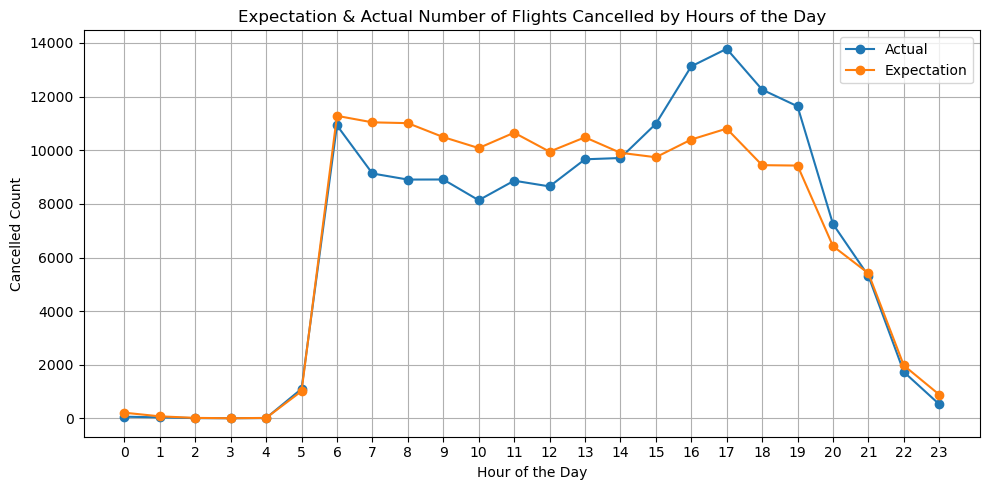

In [144]:
# Line plot for time: one line for actual one line for expected
actual = contigency_table_dict.get("cancel_with_hour_time").iloc[:,1]
expected = round(pd.DataFrame(chi2_test_dict.get("time").get('expected'), index = actual.index).iloc[:,1])
df = pd.concat([actual,expected],axis=1).reset_index()
df.columns = ['hour_time','actual_cancelled_count','expected_cancelled_count']
df['actual_vs_expected_ratio'] = df['actual_cancelled_count'] / df['expected_cancelled_count'] 
display(df)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['hour_time'], df['actual_cancelled_count'], label='Actual', marker='o')
plt.plot(df['hour_time'], df['expected_cancelled_count'], label='Expectation', marker='o')

# Labels and styling
plt.xlabel('Hour of the Day')
plt.ylabel('Cancelled Count')
plt.title('Expectation & Actual Number of Flights Cancelled by Hours of the Day')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  
plt.tight_layout()
plt.show()

### Findings
It is straightforward to see that across the whole day, the period from 15:00 to 20:00 has above-average chance to cancel the flights, peaks at 17:00. On the other hand, time period from 06:00 to 13:00 has below-average chance to cancel the flights, dips at 10:00. For other time period, it is closely following the average cancellation chance.

,dayofweek,actual_cancelled_count,expected_cancelled_count,actual_vs_expected_ratio
0,1,22287,23993.0,0.928896
1,2,25579,23262.0,1.099605
2,3,26426,23484.0,1.125277
3,4,25146,23676.0,1.062088
4,5,24217,23761.0,1.019191
5,6,15990,20130.0,0.794337
6,7,21103,22442.0,0.940335


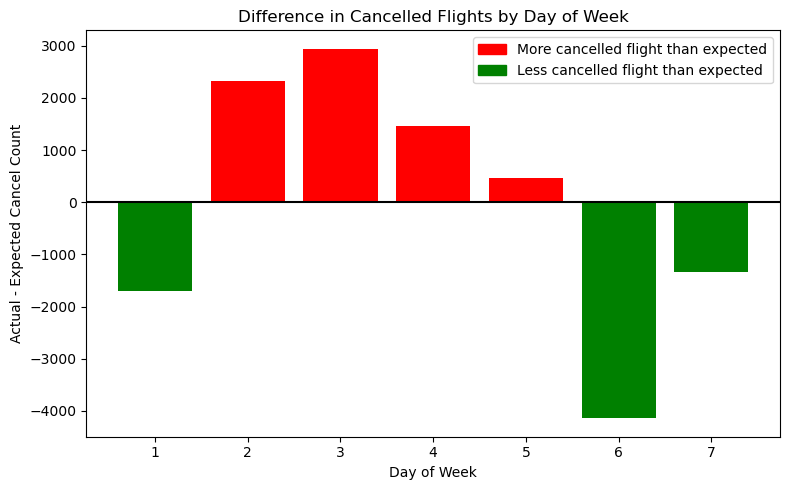

In [162]:
# Line plot for dayofweek, month, height = actual - expected
actual = contigency_table_dict.get("cancel_with_dayofweek").iloc[:,1]
expected = round(pd.DataFrame(chi2_test_dict.get("dayofweek").get('expected'), index = actual.index).iloc[:,1])
df = pd.concat([actual,expected],axis=1).reset_index()
df.columns = ['dayofweek','actual_cancelled_count','expected_cancelled_count']
df['actual_vs_expected_ratio'] = df['actual_cancelled_count'] / df['expected_cancelled_count'] 
display(df)

# Calculate difference
df['difference'] = df['actual_cancelled_count'] - df['expected_cancelled_count']

# Plot
plt.figure(figsize=(8, 5))
ax1 = plt.bar(df['dayofweek'], df['difference'], color=df['difference'].apply(lambda x: 'green' if x < 0 else 'red'))

# Labels and styling
plt.axhline(0, color='black')
plt.xlabel('Day of Week')
plt.ylabel('Actual - Expected Cancel Count')
plt.title('Difference in Cancelled Flights by Day of Week')

# Custom legedn
red_patch = mpatches.Patch(color='red', label='More cancelled flight than expected')
green_patch = mpatches.Patch(color='green', label='Less cancelled flight than expected')

plt.legend(handles=[red_patch, green_patch])
plt.tight_layout()
plt.show()

### Findings
This graph is also clear that flight cancellation situation is better around weekend (Saturday, Sunday, Monday), and worse in the middle of the week (Tuesday to Friday).   

,month,actual_cancelled_count,expected_cancelled_count,actual_vs_expected_ratio
3,12,21493,13246.0,1.622603
0,1,15777,13406.0,1.176861
4,2,25465,12199.0,2.087466
5,3,16877,13786.0,1.224213
6,4,11138,13256.0,0.840223
...,...,...,...,...
9,7,13506,13988.0,0.965542
10,8,12295,14090.0,0.872605
11,9,6507,12945.0,0.502665
1,10,7327,13587.0,0.539265


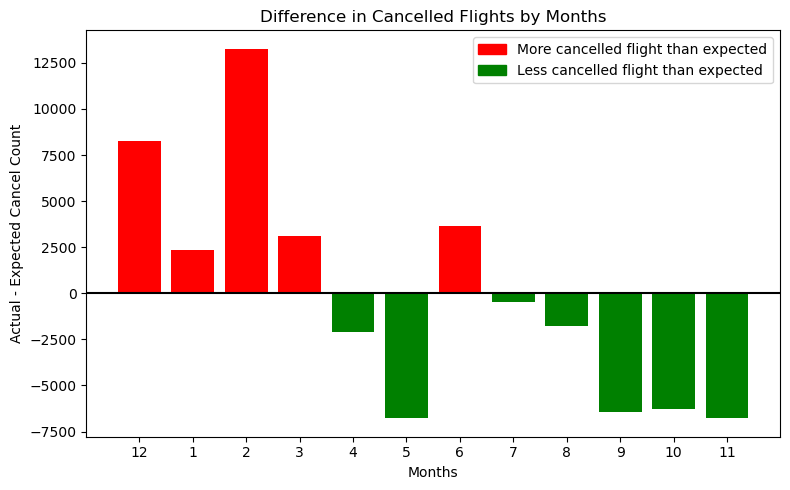

In [188]:
# Line plot for dayofweek, month, height = actual - expected
actual = contigency_table_dict.get("cancel_with_month").iloc[:,1]
expected = round(pd.DataFrame(chi2_test_dict.get("month").get('expected'), index = actual.index).iloc[:,1])
df = pd.concat([actual,expected],axis=1).reset_index()
df.columns = ['month','actual_cancelled_count','expected_cancelled_count']
df['actual_vs_expected_ratio'] = df['actual_cancelled_count'] / df['expected_cancelled_count'] 

df['month'] = df['month'].astype(int)
df = df.sort_values(by='month')
df = pd.concat([df.iloc[-1:,:],df.iloc[:-1,:]], axis=0)
display(df)

# Calculate difference
df['difference'] = df['actual_cancelled_count'] - df['expected_cancelled_count']

# Plot
plt.figure(figsize=(8, 5))
ax1 = plt.bar(df['month'].astype(str), df['difference'], color=df['difference'].apply(lambda x: 'green' if x < 0 else 'red'))

# Labels and styling
plt.axhline(0, color='black')
plt.xlabel('Months')
plt.ylabel('Actual - Expected Cancel Count')
plt.title('Difference in Cancelled Flights by Months')

# Custom legedn
red_patch = mpatches.Patch(color='red', label='More cancelled flight than expected')
green_patch = mpatches.Patch(color='green', label='Less cancelled flight than expected')

plt.legend(handles=[red_patch, green_patch])
plt.tight_layout()
plt.show()

### Findings 
Winter season (December to February) has the highest chance of cancellation, Autumn season (September to November) has the least chance of cancellation.

### Cancellation analysis: interpretation and recommendation 
It is confirmed that cancellation metrics are highly influenced by the choice of airlines, airports, and time period.   
The findings on time period is generally consistent with the analysis on delays, which in terms of cancellation rate, the best season to travel is on Autumn season, and time after 05:00 in the morning is the best. Best days of the week however is a bit different in that Tuesday has low delays but higher chance of cancellation.
  
For customers, it is recommended to avoid those airlines that are ranked the worst. However, the choice for airports is normally less flexible from a customer's perspective as the distance is a more important deciding factor, unless a much better performing airport is close by. For a suitable time period, early morning after 05:00 on a weekend is generally the best time to avoid flight cancellation. If possible, travel in second half of the year especially Autumn season but avoid June.


# 4. Problematic Routes

To quantify how problematic is a route, a new metric is defined by taking a <b>linear combination of z-score of the delays and cancellations</b>. It comes from the assumptions that departure delays and arrival delays are equally important as a metric of overall delay, and cancellation is equally important with the overall delay. Therefore, the z-score is constructed as linear combination of z-scores of departure delays, arrival delays, and cancellation with weights of <b>1:1:2</b>  

We look at several different variables:
 - Route: Route are the <b>unordered (origin, destination) pairs</b>
 - Carrier: The <b>airline</b> company itself
 - Flightnum: The flight number, usually refers to a <b>schedule</b> set by the airlines.
 - Tailnum: The <b>number plate</b> on the plane, a tailnum can uniquely identify an actual physical plane.

In [207]:
# Get the standard deviation of delay and cancellation
query = """
    SELECT
        STDDEV(depdelay) AS depdelay_std,
        AVG(depdelay) as depdelay_mean,
        STDDEV(arrdelay) AS arrdelay_std,
        AVG(arrdelay) as arrdelay_mean,      
        STDDEV(cancelled) AS cancelled_std,
        AVG(cancelled) as cancelled_mean    
    FROM airline_2007
"""
delay_cancel_mean_std = execute_to_df(query)
delay_cancel_mean_std = delay_cancel_mean_std.applymap(lambda x: float(f"{x:.4g}"))
display(delay_cancel_mean_std)

depdelay_std = delay_cancel_mean_std['depdelay_std'].values[0]
depdelay_mean = delay_cancel_mean_std['depdelay_mean'].values[0]
arrdelay_std = delay_cancel_mean_std['arrdelay_std'].values[0]
arrdelay_mean = delay_cancel_mean_std['arrdelay_mean'].values[0]
cancelled_std = delay_cancel_mean_std['cancelled_std'].values[0]
cancelled_mean = delay_cancel_mean_std['cancelled_mean'].values[0]

,depdelay_std,depdelay_mean,arrdelay_std,arrdelay_mean,cancelled_std,cancelled_mean
0,36.14,11.4,39.31,10.19,0.1453,0.02157


In [283]:
query = f"""
    SELECT
        LEAST(origin, dest) AS airport1,
        GREATEST(origin, dest) AS airport2,
        COUNT(1) AS flight_count,
        AVG( (depdelay - {depdelay_mean}) / {depdelay_std} ) AS depdelay_zscore,
        AVG( (arrdelay - {arrdelay_mean}) / {arrdelay_std} ) AS arrdelay_zscore,
        AVG( (cancelled - {cancelled_mean}) / {cancelled_std} ) AS cancelled_zscore,
        
        --Below are extra information for finding out reasons
        AVG(distance) as avg_distance,
        STDDEV(distance) as std_distance,
        AVG(taxiin) as avg_taxiin,
        STDDEV(taxiin) as std_taxiin,
        AVG(taxiout) as avg_taxiout,
        STDDEV(taxiout) as std_taxiout,
        AVG(airtime) as avg_airtime,
        STDDEV(airtime) as std_airtime,
        AVG(distance/airtime) as avg_velocity,
        STDDEV(distance/airtime) as std_velocity
    FROM airline_2007
    GROUP BY LEAST(origin, dest), GREATEST(origin, dest)
"""
problematic_route = execute_to_df(query)
display(problematic_route)

Executing ...
>>>

    SELECT
        LEAST(origin, dest) AS airport1,
        GREATEST(origin, dest) AS airport2,
        COUNT(1) AS flight_count,
        AVG( (depdelay - 11.4) / 36.14 ) AS depdelay_zscore,
        AVG( (arrdelay - 10.19) / 39.31 ) AS arrdelay_zscore,
        AVG( (cancelled - 0.02157) / 0.1453 ) AS cancelled_zscore,
        
        --Below are extra information for finding out reasons
        AVG(distance) as avg_distance,
        STDDEV(distance) as std_distance,
        AVG(taxiin) as avg_taxiin,
        STDDEV(taxiin) as std_taxiin,
        AVG(taxiout) as avg_taxiout,
        STDDEV(taxiout) as std_taxiout,
        AVG(airtime) as avg_airtime,
        STDDEV(airtime) as std_airtime,
        AVG(distance/airtime) as avg_velocity,
        STDDEV(distance/airtime) as std_velocity
    FROM airline_2007
    GROUP BY LEAST(origin, dest), GREATEST(origin, dest)

Result fetched.


,airport1,airport2,flight_count,depdelay_zscore,arrdelay_zscore,cancelled_zscore,avg_distance,std_distance,avg_taxiin,std_taxiin,avg_taxiout,std_taxiout,avg_airtime,std_airtime,avg_velocity,std_velocity
0,ABQ,COS,1,4.139458,NaN,-0.148451,280.0,0.000000e+00,0.000000,0.000000,16.000000,0.000000,NaN,NaN,NaN,NaN
1,ABQ,ORD,1238,0.121365,0.160392,0.001647,1118.0,3.733302e-14,7.154281,4.112860,15.653473,9.425344,147.491708,11.763472,7.627180,0.593995
2,ANC,IAH,522,0.241992,0.203622,-0.148451,3266.0,8.366055e-14,6.302682,3.240718,18.362069,7.386506,395.725451,16.113785,8.266911,0.337559
3,ANC,KOA,15,0.192505,0.145982,0.310369,2874.0,0.000000e+00,6.266667,2.815828,19.466667,11.224180,340.000000,14.332780,8.468065,0.359105
4,ATL,MKE,7246,0.036205,0.047934,0.003518,669.0,0.000000e+00,7.827629,5.741483,15.463152,10.159042,98.599236,8.053643,6.826388,0.532650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,CVG,MCO,2622,-0.192097,-0.169480,-0.080206,756.0,4.047239e-14,6.633486,2.438627,14.712433,6.697426,104.762914,7.088688,7.246855,0.456815
2864,DTW,IND,5630,-0.088469,0.048561,-0.013984,231.0,1.389203e-14,11.709591,4.954754,19.608348,9.305429,45.175063,5.701066,5.184211,0.578176
2865,EWR,ROC,3367,0.427551,0.358371,0.311460,246.0,0.000000e+00,7.637066,4.068777,21.329076,18.806925,48.434366,6.509146,5.156462,0.589227
2866,MSP,PVD,534,-0.130343,-0.063531,-0.071122,1116.0,0.000000e+00,7.814607,5.935144,18.288390,11.662031,150.622391,16.104253,7.488999,0.752364


In [306]:
problematic_route = problematic_route[problematic_route['flight_count'] > 40].reset_index(drop=True)
score = (problematic_route['depdelay_zscore'] + problematic_route['arrdelay_zscore'] + 2 * problematic_route['cancelled_zscore']) / 4
normalized_score = score / score.std()
problematic_route['overall_zscore'] = normalized_score

df = problematic_route.iloc[problematic_route['overall_zscore'].nlargest(1000).index,[0,1,-1]]
df['airport1'] = df['airport1'].apply(get_airport_name)
df['airport2'] = df['airport2'].apply(get_airport_name)
display(df.head(10))

,airport1,airport2,overall_zscore
1199,Nantucket Memorial,Newark Intl,5.880123
692,Aspen-Pitkin Co/Sardy,Phoenix Sky Harbor International,4.999891
31,Nantucket Memorial,John F Kennedy Intl,4.964837
1687,Aspen-Pitkin Co/Sardy,Chicago O'Hare International,4.823990
636,Minneapolis-St Paul Intl,Savannah International,3.931180
2373,John F Kennedy Intl,Norfolk International,3.720450
2387,Aspen-Pitkin Co/Sardy,San Francisco International,3.687158
2371,Indianapolis International,John F Kennedy Intl,3.504458
568,Columbia Metropolitan,LaGuardia,3.495261
2188,Columbia Metropolitan,Newark Intl,3.477480


Question: Identify specific routes (origin-destination pairs) that show consistently poor performance.  
Answer: Top ten pairs of routes that have the worst performance, these have overall z-score > 3.0, meaning they are around the top 0.3% worst performing route, according to the 68-95-99.7 empirical rule.  
- Nantucket Memorial === Newark Intl
- Aspen-Pitkin Co/Sardy	=== Phoenix Sky Harbor International
- Nantucket Memorial === John F Kennedy Intl
- Aspen-Pitkin Co/Sardy === Chicago O'Hare International
- Minneapolis-St Paul Intl === Savannah International
- John F Kennedy Intl === Norfolk International
- Aspen-Pitkin Co/Sardy === San Francisco International
- Indianapolis International === John F Kennedy Intl
- Columbia Metropolitan === LaGuardia
- Columbia Metropolitan === Newark Intl

In [315]:
top_indices = problematic_route['overall_zscore'].nlargest(100).index
df1 = problematic_route.loc[top_indices]
df2 = problematic_route.drop(top_indices)

sum_df1 = df1.mean(numeric_only=True)
sum_df2 = df2.mean(numeric_only=True)
summary_df = pd.DataFrame({'top_100': sum_df1, 'rest': sum_df2})
display(summary_df.T)

,flight_count,depdelay_zscore,arrdelay_zscore,cancelled_zscore,avg_distance,std_distance,avg_taxiin,std_taxiin,avg_taxiout,std_taxiout,avg_airtime,std_airtime,avg_velocity,std_velocity,overall_score,overall_zscore
top_100,2829.530000,0.327313,0.323794,0.335941,579.320000,1.131551e-14,7.104947,5.777339,21.271055,17.111444,90.032939,10.724556,5.989669,0.767829,2.616935,2.616935
rest,3122.103659,-0.025366,-0.035518,-0.026535,871.783972,2.316012e-14,6.486515,4.405454,15.664460,9.290098,120.208047,13.029756,6.813568,0.914348,-0.225408,-0.225408


### Findings and interpretation
When trying to understand why specific routes performs worse than other routes, we group all the routes into top 100 problematic route and the rest, then compare factors that are related to the routes, which includes the variables at airport and during the flight.  
For example:
- taxiin measure the time elapsed from leaving the departure gate until the time when wheels are off the ground; taxiout measure the time elapsed from wheels on the ground until the time when reaching the arrival gate,  
- distance measure the flight distance,  
- airtime measure the time spent on air,
- velocity measure the speed  

These variables are measured in the <b>averages</b> and <b>standard deviation</b>
When comparing averages/standard deviation of these metrics, we found several possible cause of bad performance:
- The <b>average distance for bad performing routes are much shorter</b>, 579km against 872km on other routes. This means for these routes, there are less flexibility to accomodate for any delays from any sources, as opposed to other routes which they can adjust the speed to keep up with the schedule if any delay occurs. It can also be seen from the average airtime metrics, bad performing route has only 90 minutes airtime, whereas normal routes have, on average, 30 minutes longer airtime as buffer.  
- From the taxiin/taxiout metrics, we see that problematic routes have <b>higher average time spent on the ground after departure / before arriving</b>. On average, compared to normal routes, bad routes spend 0.6 minutes longer before taking off, and spent 6 minutes longer after landing to come to a rest. Besides that, the most important difference is the standard deviation of taxiout, where bad routes has 17 minutes STD, and normal routes only have around half of it, which means it is <b>more common for bad routes to have a long taxiout delay past a certain threshold</b> of which arrival delays are unavoidable. 
- From the velocity metric, we can see <b>bad route is slower than normal route</b>, by around 15% slower. The reason cannot be conclusively determined from these simple numbers, but one can suspect that these problematic routes might have harsher weather conditions, denser air traffic etc. The lower standard deviation of bad routes also support the findings that these flights are less flexible in changing speed to adapt to any time constraint.  

In short, shorter routes are more susceptible to delays due to lack of flexibility, and the infrastructure/crews quality of the airports itself also significantly delay the departure process. Combining the previous finding that there exists effects of cascading delays, the accumulated delays directly contribute to the chance of cancelling the flights. 


In [321]:
query = f"""
    SELECT
        uniquecarrier,
        COUNT(1) as flight_count,
        AVG( (depdelay - {depdelay_mean}) / {depdelay_std} ) as depdelay_zscore,
        AVG( (arrdelay - {arrdelay_mean}) / {arrdelay_std} ) as arrdelay_zscore,
        AVG( (cancelled - {cancelled_mean}) / {cancelled_std} ) as cancelled_zscore
    FROM airline_2007
    GROUP BY uniquecarrier
"""
problematic_carrier = execute_to_df(query)
display(problematic_carrier)

Executing ...
>>>

    SELECT
        uniquecarrier,
        COUNT(1) as flight_count,
        AVG( (depdelay - 11.4) / 36.14 ) as depdelay_zscore,
        AVG( (arrdelay - 10.19) / 39.31 ) as arrdelay_zscore,
        AVG( (cancelled - 0.02157) / 0.1453 ) as cancelled_zscore
    FROM airline_2007
    GROUP BY uniquecarrier

Result fetched.


,uniquecarrier,flight_count,depdelay_zscore,arrdelay_zscore,cancelled_zscore
0,WN,1168871,-0.026657,-0.119996,-0.089613
1,AQ,46360,-0.303301,-0.294248,-0.090851
2,OH,233787,0.033416,0.074919,0.112108
3,US,485447,0.020636,0.034019,-0.021678
4,F9,97760,-0.110373,-0.070163,-0.120432
...,...,...,...,...,...
15,HA,56175,-0.339872,-0.270173,-0.119293
16,NW,414526,-0.068437,0.060268,-0.018717
17,MQ,540494,0.049619,0.071300,0.141768
18,XE,434773,0.013171,-0.004654,0.022509


,uniquecarrier,flight_count,overall_zscore,airline_name
8,EV,286234,1.511363,Atlantic Southeast Airlines
17,MQ,540494,1.102707,American Eagle Airlines Inc.
2,OH,233787,0.906668,Comair Inc.
7,AA,633857,0.797118,American Airlines Inc.
19,YV,294362,0.753167,Mesa Airlines Inc.
9,UA,490002,0.471014,United Air Lines Inc.
12,B6,191450,0.395058,JetBlue Airways
18,XE,434773,0.145958,Expressjet Airlines Inc.
3,US,485447,0.030801,US Airways Inc.
5,9E,258851,0.026451,Pinnacle Airlines Inc.


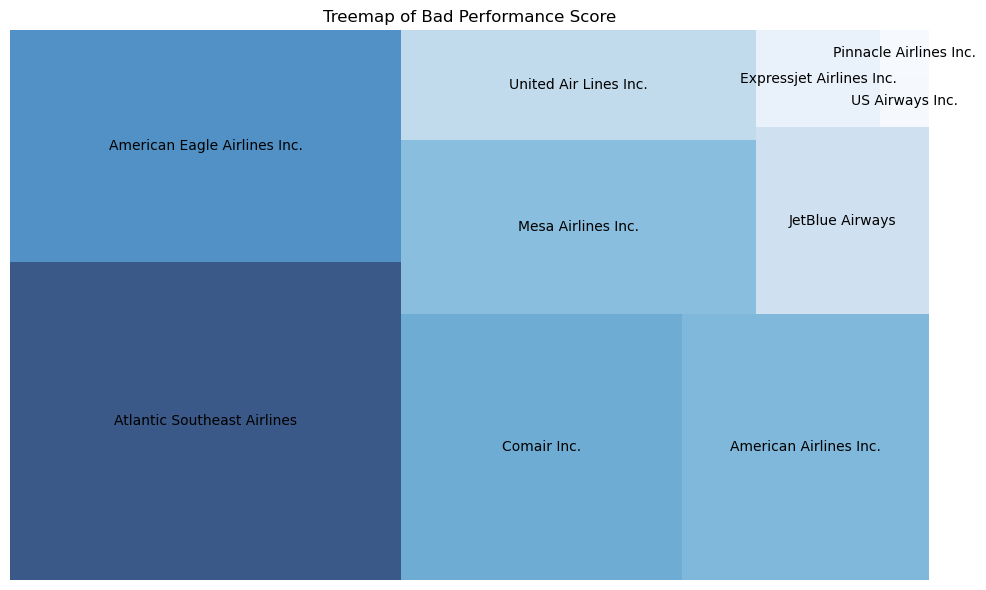

In [398]:
problematic_carrier = problematic_carrier[problematic_carrier['flight_count'] > 40].reset_index(drop=True)
score = (problematic_carrier['depdelay_zscore'] + problematic_carrier['arrdelay_zscore'] + 2 * problematic_carrier['cancelled_zscore']) / 4
normalized_score = score / score.std()
problematic_carrier['overall_zscore'] = normalized_score

df = problematic_carrier.iloc[problematic_carrier['overall_zscore'].nlargest(10).index,[0,1,-1]]
df['airline_name'] = df['uniquecarrier'].apply(get_airline_name)
display(df)

labels = df['airline_name']
sizes = df['overall_zscore']
colors = plt.cm.Blues(df['overall_zscore'] / df['overall_zscore'].max())

plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
plt.axis('off')
plt.title('Treemap of Bad Performance Score')
plt.tight_layout()
plt.show()

### Findings
The worst performing airlines are the ones with highest `overall_zscore`, the top five are:
1. Atlantic Southeast Airlines
2. American Eagle Airlines Inc.
3. Comair Inc.
4. American Airlines Inc.
5. Mesa Airlines Inc.

This results highly similar to the previous analysis about cancellation, since delays and cancellations are correlated features.

In [360]:
query = f"""
    WITH temptable AS (
        SELECT
            flightnum,
            COUNT(1) as flight_count,
            AVG( (depdelay - {depdelay_mean}) / {depdelay_std} ) as depdelay_zscore,
            AVG( (arrdelay - {arrdelay_mean}) / {arrdelay_std} ) as arrdelay_zscore,
            AVG( (cancelled - {cancelled_mean}) / {cancelled_std} ) as cancelled_zscore
        FROM airline_2007
        GROUP BY flightnum
        HAVING flight_count > 40
    ),
    temptable2 AS (
        SELECT 
            flightnum, 
            flight_count, 
            (depdelay_zscore + arrdelay_zscore + 2 * cancelled_zscore) as overall_zscore
        FROM temptable
    ),
    problematic_flightnum AS (
        SELECT 
            flightnum,
            overall_zscore
        FROM temptable2
        ORDER BY overall_zscore DESC
        LIMIT 700
    ),
    problematic_flightnum_schedule AS (
        SELECT
            'problematic' AS label,
            FLOOR(crsdeptime/100) as hour_time
        FROM airline_2007 
        WHERE flightnum IN (SELECT flightnum FROM problematic_flightnum)
    ),
    normal_flightnum_schedule AS (
        SELECT
            'normal' AS label,
            FLOOR(crsdeptime/100) as hour_time
        FROM airline_2007 
        WHERE flightnum NOT IN (SELECT flightnum FROM problematic_flightnum)    
    )
    SELECT label, hour_time, count(1) as flight_count FROM problematic_flightnum_schedule GROUP BY hour_time, label
    UNION ALL
    SELECT label, hour_time, count(1) as flight_count FROM normal_flightnum_schedule GROUP BY hour_time, label

"""

problematic_flightnum = execute_to_df(query)
display(problematic_flightnum)

Executing ...
>>>

    WITH temptable AS (
        SELECT
            flightnum,
            COUNT(1) as flight_count,
            AVG( (depdelay - 11.4) / 36.14 ) as depdelay_zscore,
            AVG( (arrdelay - 10.19) / 39.31 ) as arrdelay_zscore,
            AVG( (cancelled - 0.02157) / 0.1453 ) as cancelled_zscore
        FROM airline_2007
        GROUP BY flightnum
        HAVING flight_count > 40
    ),
    temptable2 AS (
        SELECT 
            flightnum, 
            flight_count, 
            (depdelay_zscore + arrdelay_zscore + 2 * cancelled_zscore) as overall_zscore
        FROM temptable
    ),
    problematic_flightnum AS (
        SELECT 
            flightnum,
            overall_zscore
        FROM temptable2
        ORDER BY overall_zscore DESC
        LIMIT 300
    ),
    problematic_flightnum_schedule AS (
        SELECT
            'problematic' AS label,
            FLOOR(crsdeptime/100) as hour_time
        FROM airline_2007 
        WHERE flightnum IN (SELEC

,label,hour_time,flight_count
0,problematic,10,1569
1,problematic,16,11440
2,problematic,14,7278
3,problematic,22,947
4,problematic,18,13338
...,...,...,...
37,normal,16,470732
38,normal,7,510481
39,normal,13,481530
40,normal,2,861


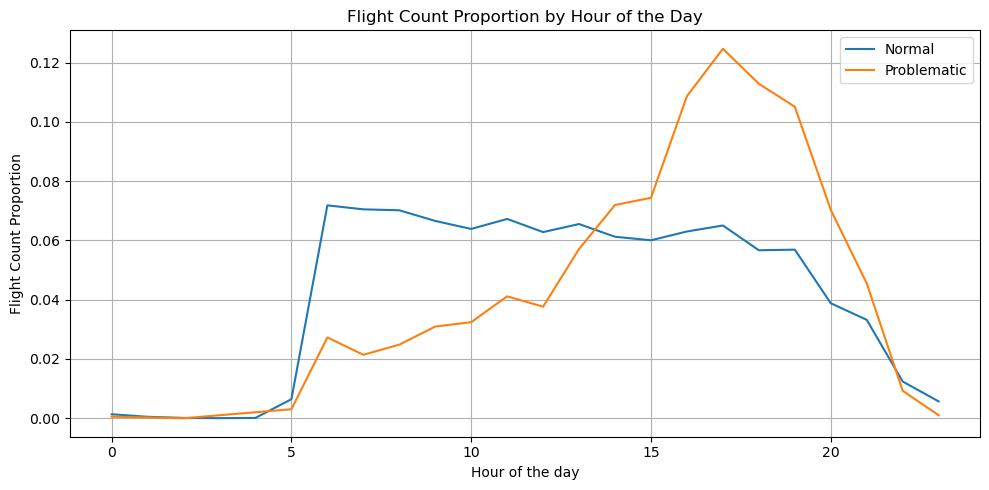

In [357]:
df_problematic = problematic_flightnum[problematic_flightnum['label'] == 'problematic'].sort_values(by='hour_time')
df_problematic['flight_count'] = df_problematic['flight_count'] / df_problematic['flight_count'].sum()
df_other = problematic_flightnum[problematic_flightnum['label'] != 'problematic'].sort_values(by='hour_time')
df_other['flight_count'] = df_other['flight_count'] / df_other['flight_count'].sum()

plt.figure(figsize=(10, 5))
plt.plot(df_other['hour_time'], df_other['flight_count'], label='Normal')
plt.plot(df_problematic['hour_time'], df_problematic['flight_count'], label='Problematic')
plt.xlabel('Hour of the day')
plt.ylabel('Flight Count Proportion')
plt.title('Flight Count Proportion by Hour of the Day')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Findings & Interpretation
The above plot is create also by using previous z-score metrics to determine which flightnum are problematics. Since flightnum are related to schedule, we try to look from the scheduled departure time by dividing all flightnum into normal and problematic ones. The problematic flightnums include the top 700 flightnum with highest z-score, 700 is chosen to represent top 10% of total 7000 different flightnum.  

The reason why these flights are problematic is as clear as day -- These flights are all focused on the evening period, and aligns with our previous findings which we found that evening periods have higher delay length and chance and also chance of cancellation. The real factors of bad performance is not flightnumber, it's the time of the day.  

The differences of problematic flightnum might be due to several reasons:
- Natural amount of traffic: The air traffic naturally higher around afternoon due to the customers' habits, and sacrifice must be made to accomodate all the demand.
- The schedule of the crew: Airports may operate with separate schedules for different crew shifts, such as morning and evening teams. The effectiveness of these schedules depends on both the quality and quantity of the available workforce. If airline management suspects that crew scheduling is a key factor behind poor performance, this area should be thoroughly investigated to confirm its impact relative to other potential causes.

In [403]:
query = f"""
    WITH temptable AS (
        SELECT
            tailnum,
            COUNT(1) as flight_count,
            AVG( (depdelay - {depdelay_mean}) / {depdelay_std} ) as depdelay_zscore,
            AVG( (arrdelay - {arrdelay_mean}) / {arrdelay_std} ) as arrdelay_zscore,
            AVG( (cancelled - {cancelled_mean}) / {cancelled_std} ) as cancelled_zscore
        FROM airline_2007
        GROUP BY tailnum
    ),
    temptable2 AS (
        SELECT 
            tailnum, 
            flight_count, 
            (depdelay_zscore + arrdelay_zscore + 2 * cancelled_zscore) as overall_zscore
        FROM temptable
    ),
    problematic_tailnum AS (
        SELECT 
            tailnum,
            overall_zscore
        FROM temptable2
        ORDER BY overall_zscore DESC
        LIMIT 200
    )
    SELECT
        'problematic' AS label,
        year as manufacture_year,
        count(1) as plane_count
    FROM problematic_tailnum t LEFT JOIN plane_data p on t.tailnum = p.tailnum
    GROUP BY year
    
    UNION ALL
    
    SELECT 
        'normal' AS label,
        p.year as manufacture_year,
        count(1) as plane_count
    FROM plane_data p
    WHERE p.tailnum NOT IN (SELECT tailnum FROM problematic_tailnum t)
    GROUP BY year
"""
problematic_tailnum = execute_to_df(query)
display(problematic_tailnum)

Executing ...
>>>

    WITH temptable AS (
        SELECT
            tailnum,
            COUNT(1) as flight_count,
            AVG( (depdelay - 11.4) / 36.14 ) as depdelay_zscore,
            AVG( (arrdelay - 10.19) / 39.31 ) as arrdelay_zscore,
            AVG( (cancelled - 0.02157) / 0.1453 ) as cancelled_zscore
        FROM airline_2007
        GROUP BY tailnum
    ),
    temptable2 AS (
        SELECT 
            tailnum, 
            flight_count, 
            (depdelay_zscore + arrdelay_zscore + 2 * cancelled_zscore) as overall_zscore
        FROM temptable
    ),
    problematic_tailnum AS (
        SELECT 
            tailnum,
            overall_zscore
        FROM temptable2
        ORDER BY overall_zscore DESC
        LIMIT 200
    )
    SELECT
        'problematic' AS label,
        year as manufacture_year,
        count(1) as plane_count
    FROM problematic_tailnum t LEFT JOIN plane_data p on t.tailnum = p.tailnum
    GROUP BY year
    
    UNION ALL
    
    SELECT 


,label,manufacture_year,plane_count
0,problematic,NaN,59
1,problematic,1987.0,2
2,problematic,1988.0,1
3,problematic,1990.0,7
4,problematic,1991.0,7
...,...,...,...
68,normal,2004.0,234
69,normal,2005.0,192
70,normal,2006.0,151
71,normal,2007.0,102


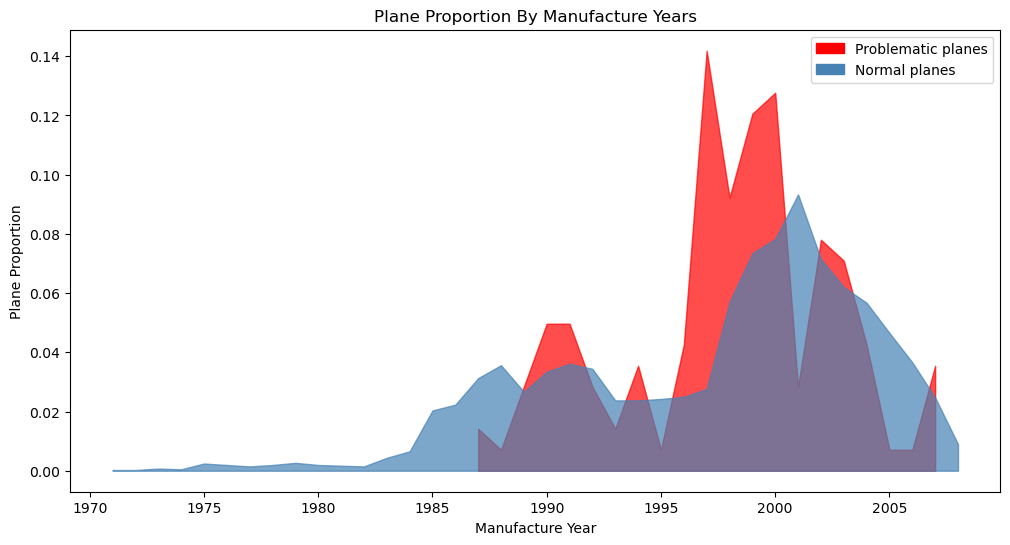

In [448]:
problematic_tailnum['manufacture_year'] = problematic_tailnum['manufacture_year'].astype(int)

df_problematic = problematic_tailnum[problematic_tailnum['label'] == 'problematic'].sort_values(by='manufacture_year')
df_problematic = df_problematic[(df_problematic['manufacture_year'] > 1970) & (df_problematic['manufacture_year'].notna())]
df_problematic['plane_count'] = df_problematic['plane_count'] / df_problematic['plane_count'].sum()

df_other = problematic_tailnum[problematic_tailnum['label'] != 'problematic'].sort_values(by='manufacture_year')
df_other = df_other[(df_other['manufacture_year'] > 1970) & (df_other['manufacture_year'].notna())]
df_other['plane_count'] = df_other['plane_count'] / df_other['plane_count'].sum()

plt.figure(figsize=(12,6))

plt.plot(df_problematic['manufacture_year'], df_problematic['plane_count'], label='Problematic', alpha=0)
plt.fill_between(df_problematic['manufacture_year'], df_problematic['plane_count'], alpha=0.7, color='red')

plt.plot(df_other['manufacture_year'], df_other['plane_count'], label='Other', alpha=0)
plt.fill_between(df_other['manufacture_year'], df_other['plane_count'], alpha=0.7, color='steelblue')

plt.xlabel('Manufacture Year')
plt.ylabel('Plane Proportion')
plt.title('Plane Proportion By Manufacture Years')

red_patch = mpatches.Patch(color='red', label='Problematic planes')
blue_patch = mpatches.Patch(color='steelblue', label='Normal planes')

plt.legend(handles=[red_patch, blue_patch])

plt.show()

### Findings
For problematic planes, close to half of the bad performing planes are manufactured between 1995 and 2001. For normal planes, there exists more newer and older planes in comparison to problematic planes.  
There is no obvious patterns to conclude the performance is affected by the manufacture year of the plane.

### Conclusion
We have analyzed the airline performance in several area such as the delay pattern, delay factors, cancellation analysis, and problematic routes etc., and the results have been shown in graph for an easy overview. For customers, they should use this information to select the airlines and best schedules to plan for their vacation / work travel. For airline companies, they should recognize how much have these factors contributed to the performance degradation of their flights. The analyses should provide a good starting direction as to where to investigate and tackle the problems presented.

From a scheduling perspective, it can be adjusted to balance loads to improve overall performance. For airlines, the operational efficiency should be investigated to reduce each and every causes that contribute to delays under "carrier reason". For airports, the facilities should be improved to make departure process smoother, more consistent, and more resistant to weather conditions. The location of the airport should also be considered in terms of traffic and routes when doing scheduling and rerouting. 

One limitation of the current analysis is the lack of modeling for the interconnectivity and flow dynamics of flight routes. Future improvements could incorporate a network-based approach, such as graph theory or complex network analysis, to capture route centrality, hub connectivity, and propagation of delays across the network. This would enable a more comprehensive understanding of systemic vulnerabilities in the airline route structure.

Overall, this analysis aims to drive data-informed decisions that improve customer satisfaction and operational efficiency across the airline industry.